In [871]:
# Importing the libraries
import glob
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [872]:
# Read all the csv files in the folder
data_list = glob.glob('Airbnb Prices in Europe/*.csv')

# Now we can use pandas to read all the csv files and combine them into one
df = pd.concat(map(pd.read_csv, data_list))

# Cross-Featuring the longitude and latitude
df['lng-lat'] = df['lng'] * df['lat'] / 1000000

# Drop the index column
df.drop(['Unnamed: 0', 'attr_index', 'rest_index', 'rest_index_norm', 'attr_index_norm', 'room_private', 'room_shared', 'cleanliness_rating', 'lng', 'lat'], axis=1, inplace=True)

df.isnull().sum()

realSum                       0
room_type                     0
person_capacity               0
host_is_superhost             0
multi                         0
biz                           0
guest_satisfaction_overall    0
bedrooms                      0
dist                          0
metro_dist                    0
lng-lat                       0
dtype: int64

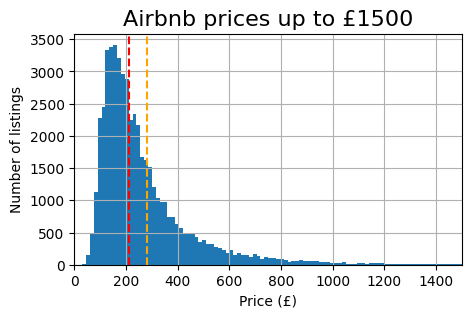

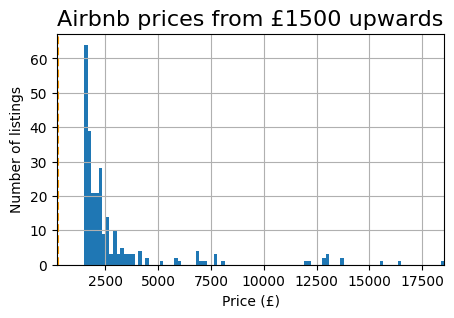

In [873]:
# Visualize the distribution of the prices up to £1500
plt.figure(figsize=(5, 3))
df.realSum.hist(bins=100, range=(0, 1500))
plt.margins(x=0)
plt.axvline(df.realSum.mean(), color='orange', linestyle='--')
plt.axvline(df.realSum.median(), color='red', linestyle='--')
plt.title("Airbnb prices up to £1500", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

# Visualize the distribution of the prices from £1500 upwards
plt.figure(figsize=(5, 3))
df.realSum.hist(bins=100, range=(1500, max(df.realSum)))
plt.margins(x=0)
plt.axvline(df.realSum.mean(), color='orange', linestyle='--')
plt.axvline(df.realSum.median(), color='red', linestyle='--')
plt.title("Airbnb prices from £1500 upwards", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

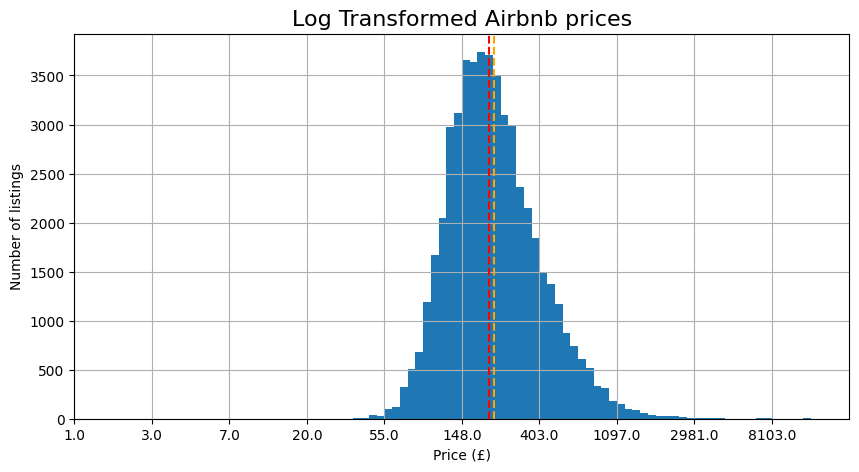

In [874]:
plt.figure(figsize=(10,5))
np.log(df.realSum).hist(bins=100, range=(0, 10))
plt.margins(x=0)

# Change the x-axis to show the actual price rounded to the nearest £
plt.xticks(np.arange(0, 10, step=1), np.exp(np.arange(0, 10, step=1)).round())

plt.axvline(np.log(df.realSum).mean(), color='orange', linestyle='--')
plt.axvline(np.log(df.realSum).median(), color='red', linestyle='--')
plt.title("Log Transformed Airbnb prices", fontsize=16)
plt.xlabel("Price (£)")
plt.ylabel("Number of listings")
plt.show()

In [875]:
# Based on the log transformed data, Setting any price above £1500 to £1500
df.realSum = np.where(df.realSum > 1500, 1500, df.realSum)

# Setting any price below £50 to £50
df.realSum = np.where(df.realSum < 50, 50, df.realSum)

<Axes: >

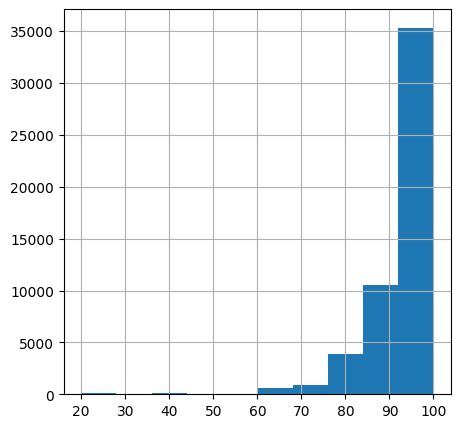

In [876]:
# Visualizing the distribution of the satisfaction rating
df.guest_satisfaction_overall.hist(figsize=(5, 5))

In [877]:
def bin_column(col, bins, labels, na_label='unknown'):
    """
    Takes in a column name, bin cut points and labels, replaces the original column with a
    binned version, and replaces nulls (with 'unknown' if unspecified).
    """
    df[col] = pd.cut(df[col], bins=bins, labels=labels, include_lowest=True)
    df[col] = df[col].astype('str')
    df[col].fillna(na_label, inplace=True)

In [878]:
# Binning cleanliness_rating column into 3 bins
bin_column('guest_satisfaction_overall',
               bins=[0, 80, 95, 100],
               labels=['0-79/100', '80-94/100', '95-100/100'],
               na_label='no reviews')

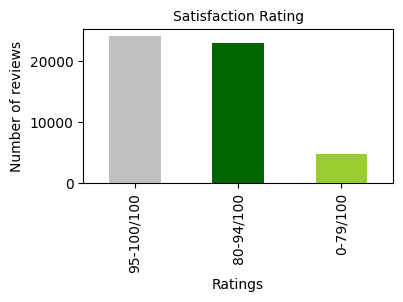

In [879]:
# Set the size of the figure
fig, ax = plt.subplots(1, 1, figsize=(4,2))

# Plot the barplot
ax.set_title('Satisfaction Rating', fontsize=10)

# Plot the barplot
df['guest_satisfaction_overall'].value_counts().sort_index(ascending=False).plot(kind='bar', color=['silver', 'darkgreen', 'yellowgreen', '#d1f28a' ], ax=ax)
ax.set_xlabel('Ratings')
ax.set_ylabel('Number of reviews', fontsize=10)
plt.show()

In [880]:
# Get the numeric columns by excluding the categorical columns
num_cols = ['realSum', 'person_capacity', 'bedrooms', 'metro_dist', 'dist', 'lng-lat']

# Get the categorical columns by excluding df columns from the numeric columns
cat_cols = [col for col in df.columns if col not in num_cols]

# Get dummy variables for categorical and boolean columns
df = pd.get_dummies(df, columns=cat_cols, drop_first=True)

# Check the first 5 rows of the dataframe
df.head()

,realSum,person_capacity,bedrooms,dist,metro_dist,lng-lat,room_type_Private room,room_type_Shared room,host_is_superhost_True,multi_1,biz_1,guest_satisfaction_overall_80-94/100,guest_satisfaction_overall_95-100/100
0,194.033698,2.0,1,5.022964,2.539380,0.000257,1,0,0,1,0,1,0
1,344.245776,4.0,1,0.488389,0.239404,0.000257,1,0,0,0,0,1,0
2,264.101422,2.0,1,5.748312,3.651621,0.000261,1,0,0,0,1,1,0
3,433.529398,4.0,2,0.384862,0.439876,0.000256,1,0,0,0,1,1,0
4,485.552926,2.0,1,0.544738,0.318693,0.000257,1,0,1,0,0,0,1


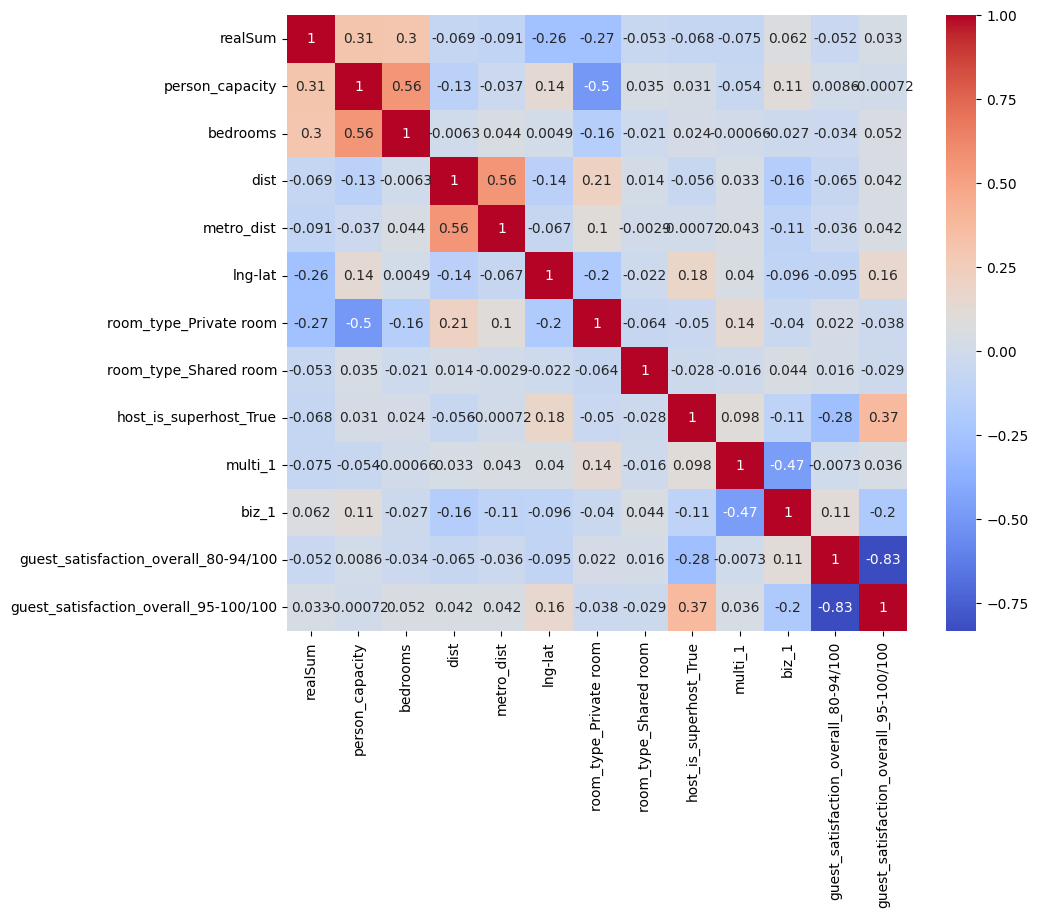

In [881]:
# Set the size of the figure
plt.figure(figsize=(10, 8))

# Plot the heatmap
sns.heatmap(df.corr(numeric_only=False), annot=True, cmap='coolwarm')
plt.show()

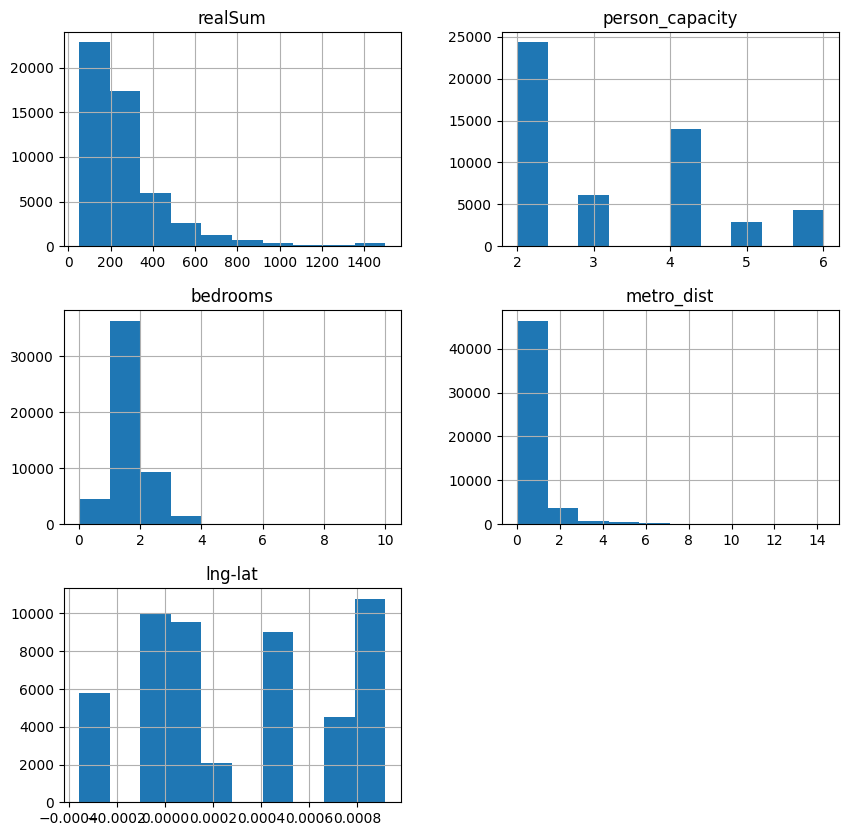

In [882]:
# Dropping the features that are highly correlated
num_cols.remove('dist')
df.drop(columns=['dist', 'guest_satisfaction_overall_95-100/100'], axis=1, inplace=True)

# Comparing the features distribution
df[num_cols].hist(figsize=(10, 10))
plt.show()

In [883]:
import numpy as np

for col in num_cols:
    df[col] = df[col].replace(0.0, 0.01)
    df[col] = np.log(df[col]+ 0.01)

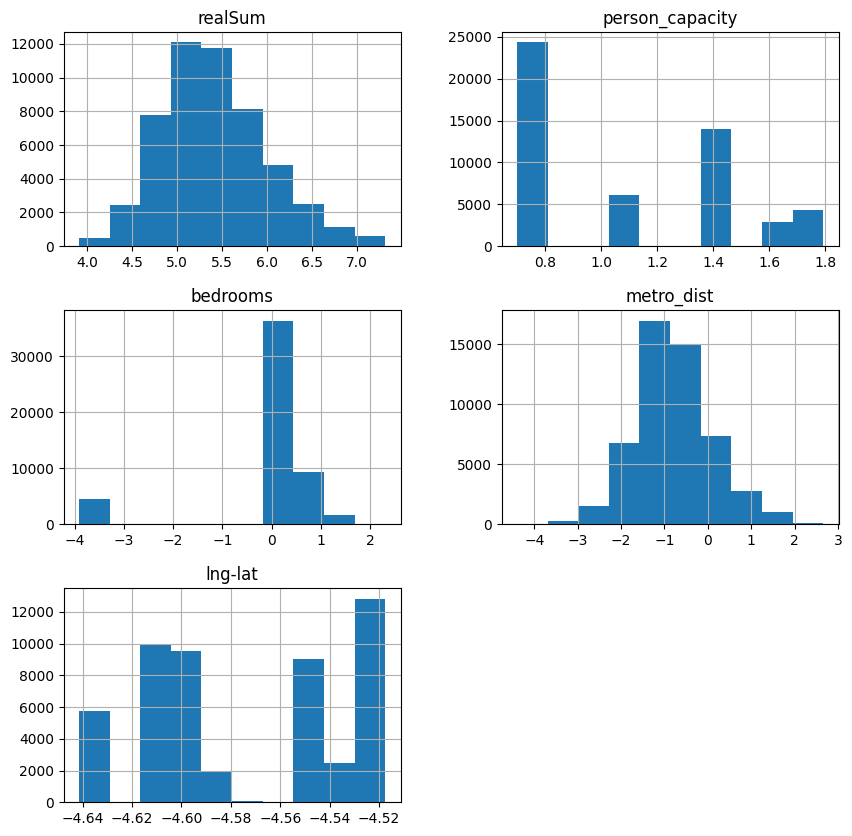

In [884]:
# Comparing the features distribution
df[num_cols].hist(figsize=(10, 10))
plt.show()

In [885]:
# Removing dropped columns from the list of categorical columns
cat_cols = [col for col in df.columns if col not in num_cols]

In [886]:
from sklearn.preprocessing import StandardScaler

# Defining the features and target
X = df.drop('realSum', axis=1)
y = df.realSum

# Scaling the features
scaler = StandardScaler()
X = pd.DataFrame(scaler.fit_transform(X), columns=list(X.columns))

In [887]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

# Split the training data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [888]:
from xgboost import XGBRegressor
from time import time
from sklearn.metrics import mean_squared_error, r2_score

xgb_start = time()

# Instantiate the model
xgb = XGBRegressor(n_estimators=500, learning_rate=0.05, n_jobs=4, early_stopping_rounds=5, random_state=42, reg_lambda=0.1)

# Fit the model
xgb.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

# Predict on the validation set
val_pred = xgb.predict(X_val)

# Predict on the training set
train_pred = xgb.predict(X_train)

xgb_end = time()

# Calculate the scores
print(f"Time taken to run: {round((xgb_end - xgb_start)/60,1)} minutes")
print("Training MSE:", round(mean_squared_error(y_train, train_pred),4))
print("Validation MSE:", round(mean_squared_error(y_val, val_pred),4))
print("Training r2:", round(r2_score(y_train, train_pred),4))
print("Validation r2:", round(r2_score(y_val, val_pred),4))

Time taken to run: 0.1 minutes
Training MSE: 0.0732
Validation MSE: 0.0909
Training r2: 0.7883
Validation r2: 0.7304
